In [33]:
import numpy as np
import math
import struct
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

Make sure data is in float32

In [65]:
stuff=np.fromfile('./rx_bits.txt',dtype='float32')
#header=np.fromfile('./header.dat',dtype='float32')
header = generate_white_noise(seed=4)
footer = generate_white_noise(seed=5)

Take real and imaginary parts of complex signal

In [66]:
arr1=stuff[::2]
arr2=stuff[1::2]

In [67]:
arr1_trim = arr1[23000:33000]
arr2_trim = arr2[23000:33000]

Make a complex signal

In [68]:
signal=arr1+(1j * arr2 )
signal_trim = arr1_trim + 1j*arr2_trim

Real signal plot

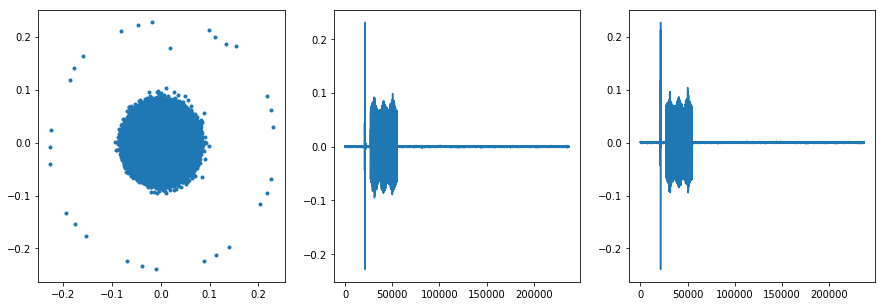

In [69]:
fullPlot(signal)

Calculate the frequency axis of the fft, then calculate the fft of the signal squared. Half of the frequency of the spike is an approximation of the frequency offset.

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


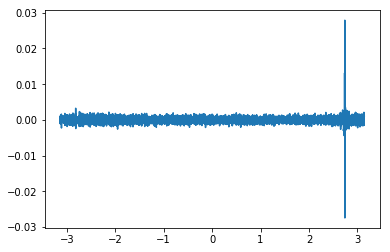

In [70]:
freq_data=np.fft.fftshift(np.fft.fft(signal_trim**4))
freq_axis=np.fft.fftfreq(len(signal_trim),(1/22050))
rad_axis= np.linspace(-np.pi, np.pi*(len(signal_trim)-1)/len(signal_trim), len(freq_data))
plt.plot(rad_axis,freq_data)

In [71]:
freq_offset=np.argmax(freq_data)/4
print("The frequency offset is {:06.2f} hertz".format(freq_axis[np.argmax(freq_data)]/4))
offset = rad_axis[np.argmax(freq_data)]/4
print("The frequency offset is {:06.5f} radians".format(offset))

The frequency offset is -353.35 hertz
The frequency offset is 0.68478 radians


(0.263944419106+0.0539240463505j)


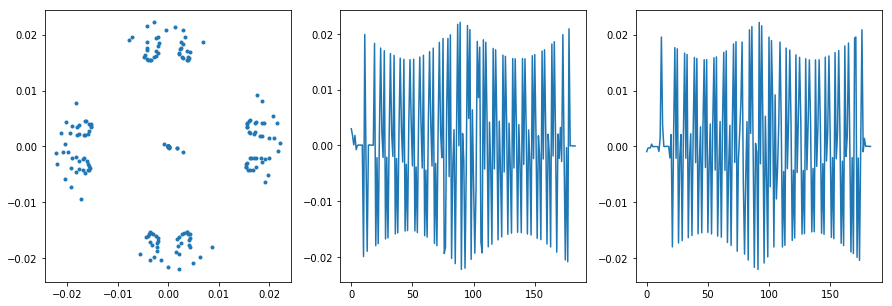

In [97]:
trimmed = autoTrim(signal,header,footer)
sampled=sample(trimmed)
res = sampled#*(1j)
fullPlot(res)

In [98]:
expectation=[-1, -1, -1, -1, -1, 0, 3, 1, 2, -1, -1, -1, -1, -1, 1, 2, 3, 2, 0, 1, 0, 3, 1, 2, 3, 2, 0, 1, 0, 3, 1, 2, 3, 2, 0, 1, 0, 3, 1, 2, 3, 2, 0, 1, 0, 3, 1, 2, 3, 2, 0, 1, 0, 3, 1, 2, 3, 2, 0, 1, 0, 3, 1, 2, 3, 2, 0, 1, 0, 3, 1, 2, 3, 2, 0, 1, 0, 3, 1, 2, 3, 2, 0, 1, 0, 3, 1, 2, 3, 2, 0, 1, 0, 3, 1, 2, 3, 2, 0, 1, 0, 3, 1, 2, 3, 2, 0, 1, 0, 3, 1, 2, 3, 2, 0, 1, 0, 3, 1, 2, 3, 2, 0, 1, 0, 3, 1, 2, 3, 2, 0, 1, 0, 3, 1, 2, 3, 2, 0, 1, 0, 3, 1, 2, 3, 2, 0, 1, 0, 3, 1, 2, 3, 2, 0, 1, 0, 3, 1, 2, 3, 2, 0, 1, 0, 3, 1, 2, 3, 2, 0, 1, 0, 3, -1, -1, -1, -1, -1]

In [99]:
received_bits = list(parse(res, threshold=.01))
if len(expectation) != len(received_bits):
    print('padding')
    print(len(expectation),len(received_bits))
    expectation = [-1] * np.absolute(len(received_bits)-len(expectation)) + expectation

# print(expectation)
error = [bin(a^b).count("1") for a,b in zip(expectation, received_bits)]
print(error)

padding
179 184
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


In [100]:
print(received_bits)

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 3, 1, 1, -1, -1, -1, -1, -1, 2, 1, 0, 1, 3, 2, 3, 0, 2, 1, 0, 1, 3, 2, 3, 0, 2, 1, 0, 1, 3, 2, 3, 0, 2, 1, 0, 1, 3, 2, 3, 0, 2, 1, 0, 1, 3, 2, 3, 0, 2, 1, 0, 1, 3, 2, 3, 0, 2, 1, 0, 1, 3, 2, 3, 0, 2, 1, 1, 3, 2, 0, 2, 1, 0, 3, 1, 3, 2, 0, 3, 0, 2, 1, 0, 1, 3, 2, 3, 0, 2, 1, 0, 1, 3, 2, 3, 0, 0, 3, 1, 3, 2, 0, 2, 1, 0, 3, 1, 3, 2, 0, 2, 1, 0, 3, 1, 3, 2, 0, 2, 1, 0, 3, 1, 3, 2, 0, 2, 1, 0, 3, 1, 3, 2, 0, 2, 1, 0, 3, 1, 3, 2, 0, 2, 1, 0, 3, 1, 3, 2, 0, 2, 1, 0, 3, 1, 3, 2, 0, 2, 1, 3, 0, 2, 0, 1, 1, 0, 3, -1, -1, -1, -1, -1]


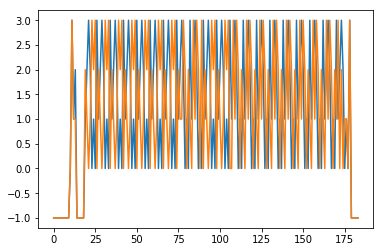

In [101]:
plt.plot(expectation)
plt.plot(received_bits)

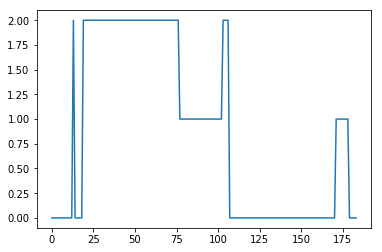

In [64]:
plt.plot(error)

## Functions

In [4]:
def approxPhaseCorrect(raw_sig,rate=22050,verbose=False):
    """Applies a approximate phase correction to a complex signal, returning the corrected signal"""
    duration = len(raw_sig)
    freq_data = np.fft.fftshift(np.fft.fft(raw_sig**4))
    rad_axis= np.linspace(-np.pi, np.pi*(duration-1)/duration, len(freq_data))
    if verbose:
        pass
    peak = np.argmax(freq_data)
    print(freq_data[peak])
    offset = rad_axis[peak]/4
    correction = -np.exp(-1j*np.linspace(0,duration-1,duration)*offset)
    return raw_sig*correction*freq_data[peak]

def generate_white_noise(seed=None):
    mean = 0
    std = 1
    num_samples = 5000
    np.random.seed(seed)
    samples = np.random.normal(mean, std, size=num_samples)
    header=samples + (1j * samples)
    return header

In [5]:
def argand(signal):
    """Plots an argand diagram of a complex signal"""
    plt.plot(np.real(signal),np.imag(signal), marker='.',linestyle='')
    
def fullPlot(signal):
    """Plots an argand diagram of a complex signal, along with the real and complex components in time"""
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    argand(signal)
    
    plt.subplot(132)
    plt.plot(np.real(signal))
    
    plt.subplot(133)
    plt.plot(np.imag(signal))
    
    plt.show()

In [6]:
def autoTrim(raw_signal, header, footer):
    signal = approxPhaseCorrect(raw_signal)
    header_corr = np.correlate(signal, header, mode="valid")
    footer_corr = np.correlate(signal, footer, mode="valid")
    start_time = np.argmax(np.absolute(header_corr))
    end_time = np.argmax(np.absolute(footer_corr))
    trimmed = signal[start_time+len(header)-500:end_time]
    
    #     plt.figure(figsize=(15,8))
    #     plt.subplot(411)
    #     plt.plot(np.real(signal))
    #     plt.subplot(412)
    #     plt.plot(np.real(header_corr))
    #     plt.subplot(413)
    #     plt.plot(np.real(footer_corr))
    #     plt.subplot(414)
    #     plt.plot(trimmed)

    #     print("start: {}".format(start_time))
    #     print("end: {}".format(end_time))
    
    return trimmed

In [21]:
def parse(signal, threshold=0.05):
    for sample in signal:
        if np.absolute(np.real(sample))+np.absolute(np.imag(sample)) < threshold:
            yield(-1)
            continue
        if np.real(sample) < 0:
            if np.imag(sample) < 0:
                yield(0)
            else:
                yield(1)
        else:
            if np.imag(sample) < 0:
                yield(2)
            else:
                yield(3)

In [8]:
def sample(signal, offset=40, bucket=20, period=100):
    length = len(signal)
    num_pads = int(period * np.ceil(length/period))-length
#     pads = (int(np.floor(num_pads/2)), int(np.ceil(num_pads/2)))
    signal_padded = np.pad(signal, (0,num_pads), 'constant', constant_values=np.NaN)
    signal_reshaped = np.reshape(signal_padded, (-1, period))
    signal_sliced = signal_reshaped[:, range(offset, offset+bucket+1)]
    signal_mean = np.nanmean(signal_sliced, axis=1)
    return signal_mean